In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from datetime import datetime

In [2]:
df = pd.read_csv("cumulative_readings_data.csv")

In [3]:
df

,Datetime,MeterA_ID,MeterA_reading,MeterB_ID,MeterB_reading,MeterC_ID,MeterC_reading
0,2025-01-01 00:00:00,SMR89133A,0.391026,SMR89133B,0.496774,SMR89133C,0.445189
1,2025-01-01 01:00:00,SMR89134A,0.829049,SMR89134B,1.220552,SMR89134C,0.792778
2,2025-01-01 02:00:00,SMR89135A,1.301743,SMR89135B,1.866084,SMR89135C,1.119703
3,2025-01-01 03:00:00,SMR89136A,1.629477,SMR89136B,2.613077,SMR89136C,1.667933
4,2025-01-01 04:00:00,SMR89137A,1.987428,SMR89137B,3.252273,SMR89137C,2.378239
...,...,...,...,...,...,...,...
5036,2025-07-29 20:00:00,SMR94144A,7146.926460,SMR94144B,7206.601816,SMR94144C,7126.940019
5037,2025-07-29 21:00:00,SMR94145A,7150.075616,SMR94145B,7208.008359,SMR94145C,7129.959548
5038,2025-07-29 22:00:00,SMR94146A,7150.377423,SMR94146B,7208.751211,SMR94146C,7130.419769
5039,2025-07-29 23:00:00,SMR94147A,7151.164962,SMR94147B,7209.316653,SMR94147C,7131.091531


In [4]:
timestamp_col="Datetime"
meter_cols=['MeterA_reading', 'MeterB_reading', 'MeterC_reading']

df = df.dropna(subset=[timestamp_col])

df = df.sort_values(by=timestamp_col)

duplicate_mask = df.duplicated(subset=[timestamp_col] + meter_cols, keep='first')
df.loc[duplicate_mask, meter_cols] = float('nan')

Q1 = df[meter_cols].quantile(0.25)
Q3 = df[meter_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (df[meter_cols] < lower_bound) | (df[meter_cols] > upper_bound)
for i in range(len(meter_cols)):
    df.loc[outlier_mask.iloc[:,i], meter_cols[i]] = float('nan')

df.isna().sum()


Datetime           0
MeterA_ID          0
MeterA_reading    40
MeterB_ID          0
MeterB_reading    33
MeterC_ID          0
MeterC_reading    44
dtype: int64

In [5]:
required_df = df[['MeterA_reading', 'MeterB_reading', 'MeterC_reading']]
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(required_df)

In [6]:
df.drop(columns=['MeterA_reading', 'MeterB_reading', 'MeterC_reading'], inplace=True)

In [7]:
new_df = pd.concat([pd.DataFrame(data_imputed, columns=['MeterA_reading', 'MeterB_reading', 'MeterC_reading']), df], axis=1)
new_df.set_index('Datetime', inplace=True)
new_order = ['MeterA_ID', 'MeterA_reading', 'MeterB_ID', 'MeterB_reading', 'MeterC_ID', 'MeterC_reading']
new_df = new_df[new_order]

In [8]:
new_df

,MeterA_ID,MeterA_reading,MeterB_ID,MeterB_reading,MeterC_ID,MeterC_reading
Datetime,,,,,,
2025-01-01 00:00:00,SMR89133A,0.391026,SMR89133B,0.496774,SMR89133C,0.445189
2025-01-01 01:00:00,SMR89134A,0.829049,SMR89134B,1.220552,SMR89134C,0.792778
2025-01-01 02:00:00,SMR89135A,1.301743,SMR89135B,1.866084,SMR89135C,1.119703
2025-01-01 03:00:00,SMR89136A,1.629477,SMR89136B,2.613077,SMR89136C,1.667933
2025-01-01 04:00:00,SMR89137A,1.987428,SMR89137B,3.252273,SMR89137C,2.378239
...,...,...,...,...,...,...
2025-07-29 20:00:00,SMR94144A,7146.926460,SMR94144B,7206.601816,SMR94144C,7126.940019
2025-07-29 21:00:00,SMR94145A,7150.075616,SMR94145B,7208.008359,SMR94145C,7129.959548
2025-07-29 22:00:00,SMR94146A,7150.377423,SMR94146B,7208.751211,SMR94146C,7130.419769


In [9]:
new_df.isna().sum()

MeterA_ID         0
MeterA_reading    0
MeterB_ID         0
MeterB_reading    0
MeterC_ID         0
MeterC_reading    0
dtype: int64

In [10]:
new_df.to_csv("cleaned_df.csv")

<Axes: xlabel='Datetime'>

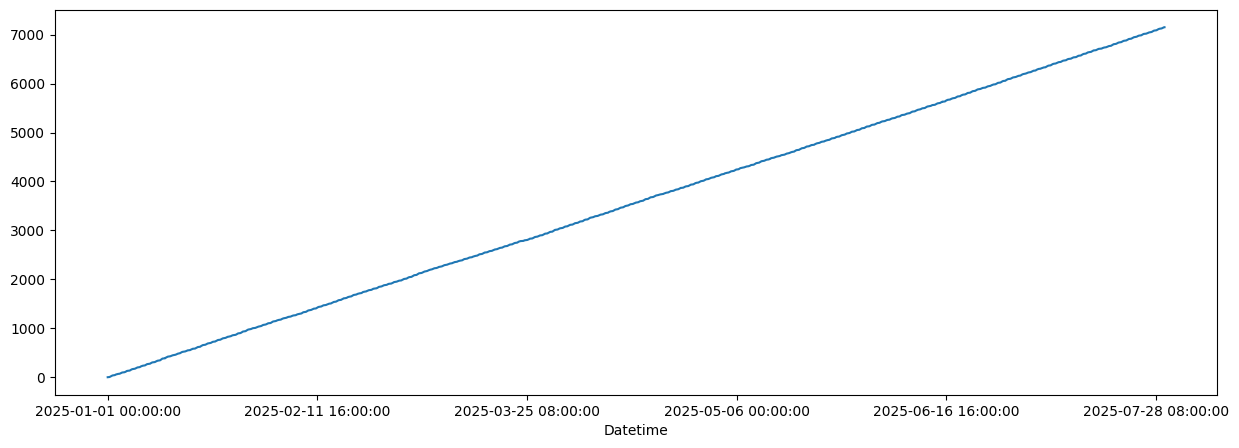

In [11]:
new_df['MeterA_reading'].plot(figsize=(15,5))